In diesem Notebook werden Bilder mit den assoziierten Sensordaten dargestellt.

In [19]:
import pandas
import seaborn as sns
%matplotlib inline 
import matplotlib.pyplot as plt
import os
import numpy as np

In [3]:
# Lesen der Merkmale
featuresDf = pandas.read_csv("merkmale.csv")
featuresDf.describe()

,Zeitstempel,Breitengrad,Laengengrad,Geschwindigkeit,Messwerte,StartBewegungsD,StartBelichtung,Belichtungszeit,MittelX,MittelY,...,VarianzX,VarianzY,VarianzZ,VarianzNick,VarianzRoll,AbweichungX,AbweichungY,AbweichungZ,AbweichungNick,AbweichungRoll
count,4.164000e+03,4164.000000,4164.000000,4164.000000,4164.0,4.164000e+03,4.164000e+03,4.164000e+03,4164.000000,4164.000000,...,4164.000000,4164.000000,4164.000000,4164.000000,4164.000000,4164.000000,4164.000000,4164.000000,4164.000000,4164.000000
mean,1.520233e+12,53.613483,10.137698,0.007556,10.0,2.264945e+14,2.264947e+14,3.279630e+07,-0.000613,-0.000108,...,0.000432,0.000201,0.000631,0.000003,0.000014,0.015147,0.013235,0.019368,0.000461,0.000848
std,4.067961e+05,0.000021,0.000039,0.128715,0.0,4.067913e+11,4.067962e+11,4.655649e+05,0.025055,0.008104,...,0.004887,0.000521,0.004595,0.000033,0.000215,0.014246,0.005123,0.015996,0.001560,0.003673
min,1.520233e+12,53.613420,10.137633,0.000000,10.0,2.257848e+14,2.257849e+14,2.999632e+07,-1.293692,-0.274551,...,0.000010,0.000000,0.000020,0.000000,0.000000,0.003160,0.000000,0.004470,0.000000,0.000000
25%,1.520233e+12,53.613472,10.137681,0.000000,10.0,2.261525e+14,2.261526e+14,3.287369e+07,-0.002702,-0.002960,...,0.000130,0.000120,0.000180,0.000000,0.000000,0.011400,0.010950,0.013420,0.000000,0.000000
50%,1.520233e+12,53.613490,10.137691,0.000000,10.0,2.265032e+14,2.265034e+14,3.287369e+07,-0.000101,-0.000161,...,0.000180,0.000160,0.000260,0.000000,0.000000,0.013420,0.012650,0.016120,0.000000,0.000000
75%,1.520234e+12,53.613500,10.137706,0.000000,10.0,2.268460e+14,2.268462e+14,3.287369e+07,0.002587,0.002808,...,0.000260,0.000230,0.000380,0.000000,0.000000,0.016120,0.015170,0.019490,0.000000,0.000000
max,1.520234e+12,53.613533,10.137800,3.420000,10.0,2.271917e+14,2.271919e+14,3.287369e+07,0.323269,0.154181,...,0.236390,0.028030,0.255660,0.001950,0.009370,0.486200,0.167420,0.505630,0.044160,0.096800


In [4]:
featuresDf.columns

Index(['Zeitstempel', 'Breitengrad', 'Laengengrad', 'Geschwindigkeit',
       'AccelerometerX', 'AccelerometerY', 'AccelerometerZ', 'Azimuth', 'Nick',
       'Roll', 'SensorZeitstempel', 'Messwerte', 'StartBewegungsD',
       'StartBelichtung', 'Belichtungszeit', 'MittelX', 'MittelY', 'MittelZ',
       'MittelNick', 'MittelRoll', 'AzimuthAenderung', 'VarianzX', 'VarianzY',
       'VarianzZ', 'VarianzNick', 'VarianzRoll', 'AbweichungX', 'AbweichungY',
       'AbweichungZ', 'AbweichungNick', 'AbweichungRoll'],
      dtype='object')

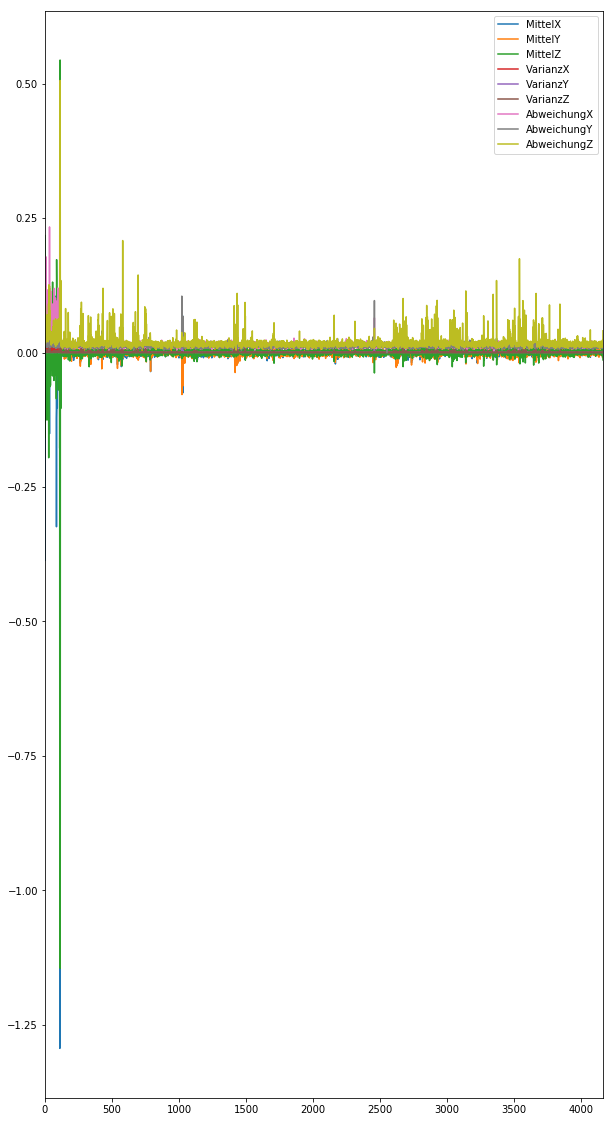

In [29]:
# Plot in welchem Beschleunigungssensordaten zu dem entsprechenden Zeitfenster 
# gegenübergestellt werden.
sensorTimestampsDf = pandas.DataFrame(np.array(featuresDf.SensorZeitstempel.str.split(" ").tolist()).astype(float))
accDf = featuresDf[['AccelerometerX','AccelerometerY','AccelerometerZ','MittelX','MittelY','MittelZ'
                   ,'VarianzX','VarianzY','VarianzZ','AbweichungX','AbweichungY','AbweichungZ']]
accDf.plot.line(figsize=(10,20))